### Conputer vision project: Cassava disease detection.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !cp "/content/drive/My Drive/ammi-2020-convnets.zip" /content
# !unzip "ammi-2020-convnets.zip"

In [0]:
!mkdir ~/.kaggle
!echo '{"username":"zeinabalmahdi","key":"e990b70a4fb3a04230f6ee1ef1c66be0"}' > ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c cassava-disease

 99% 1.03G/1.04G [00:18<00:00, 60.2MB/s]
100% 1.04G/1.04G [00:18<00:00, 60.3MB/s]
 95% 489M/515M [00:04<00:00, 117MB/s]
100% 515M/515M [00:04<00:00, 110MB/s]
 99% 771M/777M [00:10<00:00, 104MB/s] 
100% 777M/777M [00:11<00:00, 74.0MB/s]
  0% 0.00/645k [00:00<?, ?B/s]
100% 645k/645k [00:00<00:00, 90.1MB/s]
  0% 0.00/83.8k [00:00<?, ?B/s]
100% 83.8k/83.8k [00:00<00:00, 83.0MB/s]


In [0]:
%%capture
!unzip -n train.zip
!unzip -n test.zip
!unzip -n extraimages.zip

In [0]:
# !pip install albumenatations

In [0]:
#### import packages 
import torch 
from torch import nn, optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms,datasets, models
from skimage import io , transform
import pandas as pd 
import numpy as np 
import os
from PIL import Image
from matplotlib import pyplot as plt 
import cv2 
from torch import optim

import warnings 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from albumentations import (
    HorizontalFlip,RandomRotate90,CenterCrop,Compose,VerticalFlip,Rotate,RandomSizedCrop,Normalize,Resize
)
from albumentations.pytorch import ToTensor

x = {name : idx for idx,name in enumerate(os.listdir("train"))}
warnings.filterwarnings("ignore")

In [0]:
x

{'cbb': 1, 'cbsd': 3, 'cgm': 0, 'cmd': 2, 'healthy': 4}

In [0]:
# #### Set deterministic random operation for the notebook.....
# def setup_seed(seed=101):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True

In [0]:
len(os.listdir("extraimages"))

12596

### Exploratory analysis of data. 

In [0]:
#### checking the entire images in the folders 
#########

Total = {}
for file in os.listdir("train"):
    Total[file] = len(os.listdir(os.path.join("train",file)))
print(f"The total images in individual class: {Total} \n")

extra = len(os.listdir("extraimages"))
print("The total images in extraimages set: ",str(extra),"\n")
print("The entire images in the test: ",str(len(os.listdir("test"))))

The total images in individual class: {'cgm': 773, 'cbb': 466, 'cmd': 2658, 'cbsd': 1443, 'healthy': 316} 

The total images in extraimages set:  12596 

The entire images in the test:  1


In [0]:
os.listdir("train")

['cgm', 'cbb', 'cmd', 'cbsd', 'healthy']

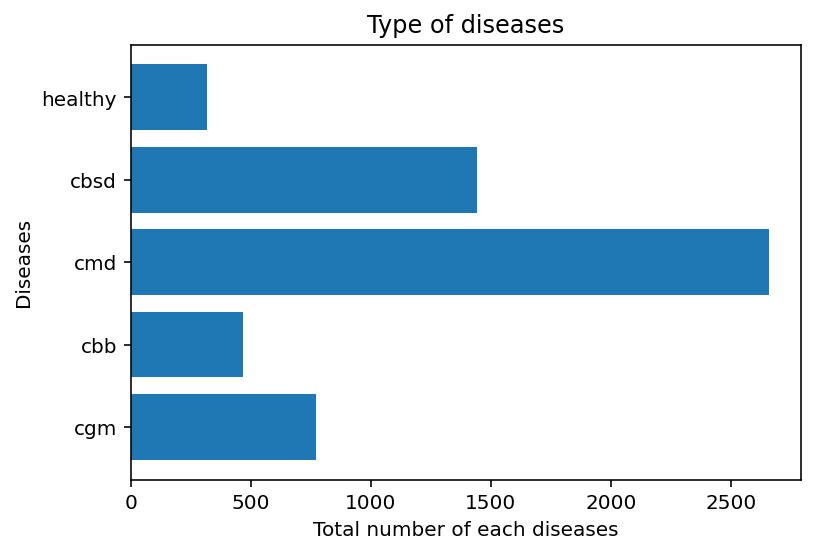

In [0]:
#### Visualization of images 

numel = np.arange(len(Total.keys()))
conditions = Total.values()
labels = Total.keys()


fig ,ax = plt.subplots()
#### Plot the level of images 

ax.barh(numel,conditions)
ax.set_yticks(numel)
ax.set_yticklabels(labels)
ax.set_ylabel("Diseases")
ax.set_title("Type of diseases")
ax.set_xlabel("Total number of each diseases")
plt.show()

### Splitting the datasets into train and validation sets 

In [0]:
#### Split the train set into train and validation set 
import random
class2label = {label : idx for idx, label in enumerate(os.listdir("train"))}

#### Get the total images, train and validation. 
total_images = {}
train_images = {}
valid_images = {}

train_path = "train"
for label in os.listdir(train_path):
    eachTotal = len(os.listdir(os.path.join(train_path,label)))
    for imgs in os.listdir(os.path.join(train_path,label)):
        img = os.path.join(train_path,label,imgs) ##an image 
        total_images[img] = class2label[label]
    valid_sets = random.sample(os.listdir(os.path.join(train_path,label)),int(eachTotal * 0.15))
    
    for img in valid_sets:
        img_ = os.path.join(train_path,label,img)
        valid_images[img_] = class2label[label]
    for imgs in os.listdir(os.path.join(train_path,label)):
        if imgs not in valid_sets:
            im_ = os.path.join(train_path,label,imgs)
            train_images[im_] = class2label[label]

print(f"The total training set: {len(total_images)} \n")        
print(f"The total training sets: {len(train_images)} \n")
print(f"The total validation set: {len(valid_images)}")

The total training set: 5656 

The total training sets: 4811 

The total validation set: 845


In [0]:
# from glob import glob 
# #### set all the path into a dictionary 
# path = {"train": "competitions/ammi-2020-convnets/train/train",
#         "test": "competitions/ammi-2020-convnets/test/test/",
#         "extraimages": "competitions/ammi-2020-convnets/extraimages/extraimages/ "}

### Loading the datasets 

In [0]:
#### Now we have to build class for the data. 

class CassavaDisease(Dataset):
    
    """
    Class object for loading datasets 
    Arguments: Takes the path to the datasets. 
    Transform image 
    mode: Train / Test 
    
    Return:
        Load the datasets from the disk. 
    """
    def __init__(self,Datasets,transform = None , mode = False,labels = class2label):
        
        self.dataset = Datasets  ### set the path to the image 
        self.transform = transform    ### transform the image 
        self.mode = mode
        self.label2class = {label : Class for Class,label in class2label.items()}
        
        if self.mode is "Train" or self.mode is "Valid":
            
            self.images , self.labels = [] , []
            
            for image, label in self.dataset.items():
                self.images.append(image)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)
        
    def __getitem__(self,idx):

        images = self.images[idx]
        labels = self.labels[idx]
        images = cv2.imread(images)

        if self.transform is not None:
            images = self.transform(image =images)["image"]

        """
        Return:
            image and label of the respective folders
        """

        return images , labels


### Data augmentation stage: 

In [0]:
def train_aug():
    return Compose([
        Resize(256,256),
        HorizontalFlip(p=0.2),
        VerticalFlip(),
        RandomRotate90(),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],max_pixel_value=225,always_apply=True),
        ToTensor()
    ])

def test_aug():
    return Compose([
        Resize(224,224),
        Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225],max_pixel_value=225,always_apply=True),
        ToTensor()
    ])
if __name__ == "__main__":
    train_aug = train_aug()
    test_aug = test_aug()

### Loading the datasets 

In [0]:
#### Access the trainset and validation sets 
trainset = CassavaDisease(train_images,mode = "Train",transform= train_aug)
validset = CassavaDisease(valid_images,mode = "Valid",transform = test_aug)

In [0]:
trainloader = DataLoader(trainset,batch_size= 32,shuffle=True)
testloader = DataLoader(validset,batch_size= 32 , shuffle= False)

In [0]:
imgs , labs = next(iter(trainloader))

### Model formulation

In [0]:
### setting the device to cuda:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [0]:
##### In the first we will pretraied model 
model = models.resnet50(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
model.fc = torch.nn.Linear(in_features=2048, out_features=5, bias=True)

In [0]:
# for param in model.parameters():
#     param.requires_grad = False 
    
from collections import OrderedDict
from torch import nn 

classifier = nn.Sequential(OrderedDict([
    ("fc1",nn.Linear(model.fc.in_features,128)),
    ("ReLU",nn.ReLU(inplace=True)),
    ("dropout",nn.Dropout(p=0.2)),
    ("fc2",nn.Linear(128,64)),
    ("ReLU",nn.ReLU()),
    ("fc3",nn.Linear(64,5))]))

In [0]:
##### Append the last layer of the classifier. 
#model.fc = classifier
model.fc = classifier

In [0]:
model.fc.parameters()

<generator object Module.parameters at 0x7f51e00c0e08>

In [0]:
len(trainloader.dataset)

4811

### Build the training loop for the model. 

In [0]:
#### time the number epoch 
from torch.optim import lr_scheduler

#### set the criterion and optimizers 
criterion = nn.CrossEntropyLoss()
Optim = optim.Adam(model.parameters(), lr = 0.001)
step_size = 30
scheduler = lr_scheduler.StepLR(Optim,step_size=step_size,gamma=0.1)
#### define the training loop 

def train(model,trainloader,criterion,optim,num_epoch,scheduler):
    
    
    model = model.to(device)
    trainloss = []
    
    model.train()
    i = 0
    for epoch in range(num_epoch):
        ###initialize the training loss at every epoch  
        correct_number = 0
        losstrain = 0 
        scheduler.step()    ##### decay the learning after 30 epoch 
        for  images,labels in trainloader:
            #### set the images and labels to device 
            images = images.to(device)
            labels = labels.to(device)
            
            #### make predictions
            preds = model(images)
            optim.zero_grad() ### not to cumulate the gradient
            loss = criterion(preds,labels)
            loss.backward()
            optim.step()
            ##### sum the loss 
            losstrain += loss.detach().item() * images.detach().size(0)

            correct_number += (preds.max(1)[1]==labels).sum()

        accuracy = 100.0 * correct_number / len(trainloader.dataset)
        Loss = losstrain / len(trainloader)
        trainloss.append(Loss)    ##store all the training loss  
        
        print("After 10 epoch of training")
        print(f"Training loss: {Loss : .2f} , Accuracy: {accuracy:.2f}  after {epoch + 1} epoch")                 
        
def valid(model,testloader):
    
    with torch.no_grad():
        #### set the model eval mode
        model.eval()
        valid_acc = 0 
        for images , labels in testloader:
            
            ### set to the gpu 
            images = images.to(device)
            labels = labels.to(device)
            
            ### predict the image
            preds = model(images)
            #### pick the maximum index of value 
            preds = preds.detach().argmax(dim=1,keepdim=True)
            labels = labels.detach()
            #correct += pred.cpu().eq(target.view_as(pred)).sum().item()
            valid_acc += preds.eq(labels.view_as(preds)).sum().item()
            
        print(f"Validation accuracy : {(valid_acc/len(testloader.dataset)) * 100 :.0f}%")   

In [0]:
###### execute the loop for each loop

if __name__ == "__main__":
    
    #### setting the training loop and test loop 
    train(model= model, trainloader=trainloader,criterion=criterion,optim=Optim,num_epoch=40,scheduler= scheduler)
    #### 
    valid(model=model,testloader=testloader)

After 10 epoch of training
Training loss:  34.89 , Accuracy: 60.72  after 1 epoch
After 10 epoch of training
Training loss:  29.98 , Accuracy: 66.47  after 2 epoch
After 10 epoch of training
Training loss:  28.21 , Accuracy: 69.38  after 3 epoch
After 10 epoch of training
Training loss:  25.18 , Accuracy: 72.77  after 4 epoch
After 10 epoch of training
Training loss:  24.20 , Accuracy: 74.35  after 5 epoch
After 10 epoch of training
Training loss:  22.56 , Accuracy: 75.45  after 6 epoch
After 10 epoch of training
Training loss:  21.26 , Accuracy: 77.49  after 7 epoch
After 10 epoch of training
Training loss:  20.07 , Accuracy: 78.65  after 8 epoch
After 10 epoch of training
Training loss:  19.72 , Accuracy: 78.82  after 9 epoch
After 10 epoch of training
Training loss:  19.79 , Accuracy: 78.51  after 10 epoch
After 10 epoch of training
Training loss:  18.33 , Accuracy: 80.57  after 11 epoch
After 10 epoch of training
Training loss:  17.69 , Accuracy: 80.98  after 12 epoch
After 10 epoc

In [0]:
valid(model=model,test`loader=testloader)